In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
sns.set(style="white")
sns.set(font='SimHei')

In [2]:
df = pd.read_csv('revlog_202012160921_clear.csv')

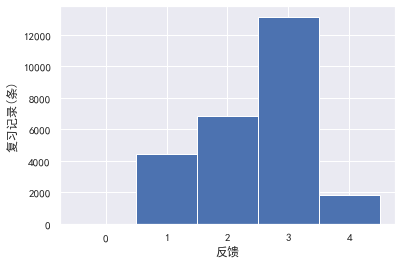

In [3]:
plt.hist(df['ease'], bins=np.arange(6)-0.5)
plt.ylabel('复习记录(条)')
plt.xlabel('反馈')
plt.show()

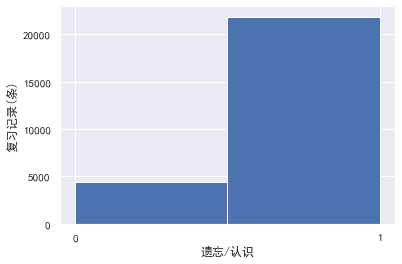

In [4]:
plt.hist(df['p'], bins=2)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.ylabel('复习记录(条)')
plt.xlabel('遗忘/认识')
plt.show()

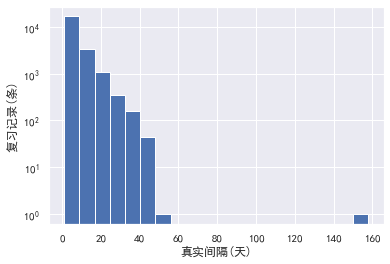

In [17]:
plt.hist([x for x in df['used_interval']], bins=20)
plt.xlabel('真实间隔(天)')
plt.ylabel('复习记录(条)')
plt.yscale('log')
plt.show()

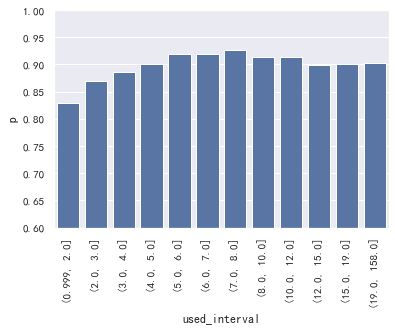

In [18]:
def _compute_bin_p_recall(group):
    return pd.DataFrame([
        {'p': group['p'].mean()}
    ])
global_forgetting = df.groupby(
    pd.qcut(df['used_interval'], 20, duplicates="drop")
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)
sns.barplot(x='used_interval', y='p', data=global_forgetting, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.6, 1)
plt.show()

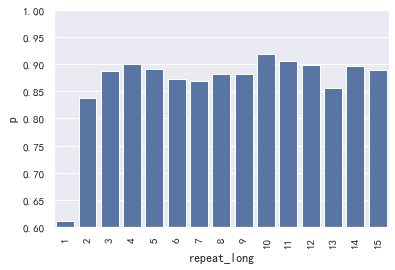

In [7]:
global_repeat_long = df.groupby(
    df['repeat_long']
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)[:15]
sns.barplot(x='repeat_long', y='p', data=global_repeat_long, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.6, 1)
plt.show()

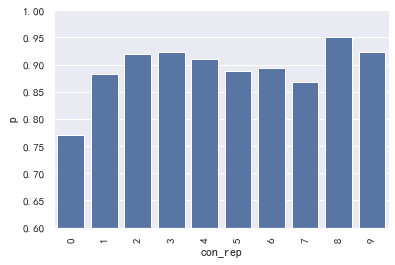

In [21]:
global_repeat_long = df.groupby(
    df['con_rep']
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)[:10]
sns.barplot(x='con_rep', y='p', data=global_repeat_long, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.6, 1)
plt.show()

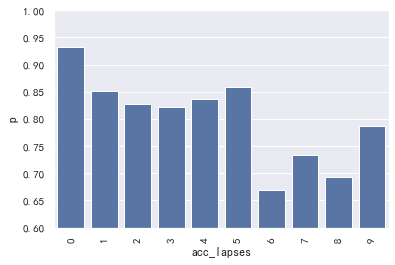

In [23]:
global_repeat_long = df.groupby(
    df['acc_lapses']
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)[:10]
sns.barplot(x='acc_lapses', y='p', data=global_repeat_long, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.6, 1)
plt.show()

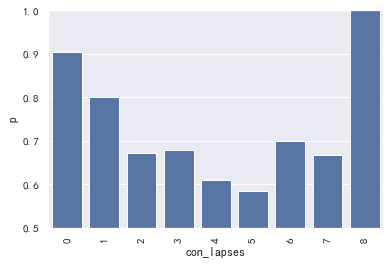

In [25]:
global_repeat_long = df.groupby(
    df['con_lapses']
).apply(_compute_bin_p_recall).reset_index().drop(['level_1'], axis=1)[:10]
sns.barplot(x='con_lapses', y='p', data=global_repeat_long, color=sns.color_palette()[0])
plt.xticks(rotation=90)
plt.ylim(0.5, 1)
plt.show()

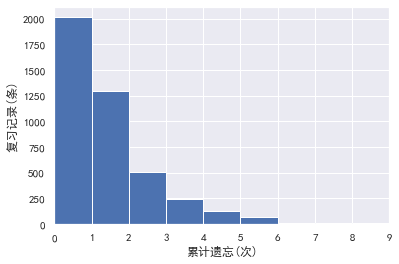

In [20]:
plt.hist([x for x in df.drop_duplicates(['cid'], keep='last')['acc_lapses'] if x <= 10], bins=10)
plt.xlim(0, 9)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('累计遗忘(次)')
plt.ylabel('复习记录(条)')
# plt.yscale('log')
plt.show()

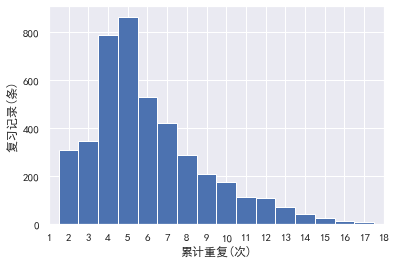

In [19]:
plt.hist([
    x for x in df.drop_duplicates(['cid'], keep='last')['repeat_long']
    if x <= 18
], bins=np.arange(18+1)-0.5)
plt.xlim(1, 18)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('累计重复(次)')
plt.ylabel('复习记录(条)')
# plt.yscale('log')
plt.show()

In [9]:
df.drop(df[df['type'] == 0].index, inplace=True)
df.head()

,cid,type,repeat_long,acc_lapses,con_lapses,acc_rep,con_rep,used_interval,lastIvl,ease,p
1,1554031768886,1,2,1,1,0,0,3.0,4,1,0
2,1554031768886,1,3,2,2,0,0,1.0,1,4,1
3,1554031768886,1,4,2,0,1,1,4.0,4,3,1
4,1554031768886,1,5,2,0,2,2,11.0,10,3,1
5,1554031768886,3,6,2,0,3,3,24.0,25,1,0


In [10]:
df['pp'] = np.exp(np.log(0.9) 
                       * df.used_interval.values 
                       / df.lastIvl.values)

AUC: 0.5012195342823786


<Figure size 432x288 with 0 Axes>

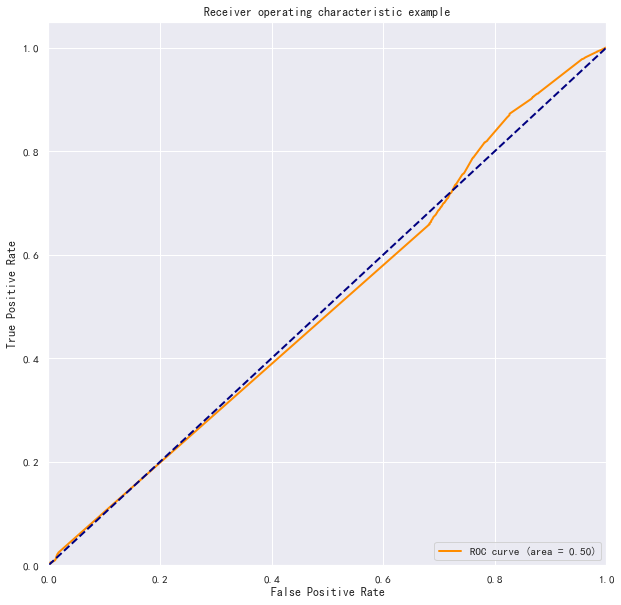

In [11]:
fpr, tpr, threshold = roc_curve(df['p'], df['pp'])
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)
plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  # 假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [12]:
def load_brier(predictions, real, bins=20):
    counts = np.zeros(bins)
    correct = np.zeros(bins)
    prediction = np.zeros(bins)
    for p, r in zip(predictions, real):
        bin = min(int(p * bins), bins - 1)
        counts[bin] += 1
        correct[bin] += r
        prediction[bin] += p
    prediction_means = prediction / counts
    prediction_means[np.isnan(prediction_means)] = ((np.arange(bins) + 0.5) / bins)[np.isnan(prediction_means)]
    correct_means = correct / counts
    # correct_means[np.isnan(correct_means)] = 0
    size = len(predictions)
    answer_mean = sum(correct) / size
    return {
        "reliability": sum(counts * (correct_means - prediction_means) ** 2) / size,
        "resolution": sum(counts * (correct_means - answer_mean) ** 2) / size,
        "uncertainty": answer_mean * (1 - answer_mean),
        "detail": {
            "bin_count": bins,
            "bin_counts": list(counts),
            "bin_prediction_means": list(prediction_means),
            "bin_correct_means": list(correct_means),
        }
    }


def plot_brier(predictions, real, bins=20):
    brier = load_brier(predictions, real, bins=bins)
    plt.figure()
    plt.plot((0, 1), (0, 1), label='Optimal average observation')
    plt.plot(brier['detail']['bin_prediction_means'], brier['detail']['bin_correct_means'],  '*', label='Average observation',)
    bin_count = brier['detail']['bin_count']
    counts = np.array(brier['detail']['bin_counts'])
    bins = (np.arange(bin_count) + 0.5) / bin_count
    plt.legend(loc='upper center')
    plt.xlabel('Prediction')
    plt.ylabel('Observeation')
    plt.twinx()
    plt.ylabel('Number of predictions')
    plt.bar(bins, counts, width=(0.5 / bin_count), alpha=0.5, label='Number of predictions')
    plt.legend(loc='lower center')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


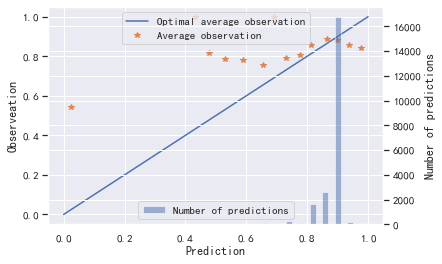

In [13]:
plot_brier(df['pp'], df['p'], 25)
plt.show()

In [14]:
print('mean recall', np.mean(df['p']))
print('MAE:', mean_absolute_error(df['p'], df['pp']))
print('RMSE:', np.sqrt(mean_squared_error(df['p'], df['pp'])))
print('LL:', log_loss(df['p'], df['pp']))
print('r2_score:', r2_score(df['p'], df['pp']))

mean recall 0.8785882136110215
MAE: 0.20878185028024598
RMSE: 0.32791772616061027
LL: 0.373779097344306
r2_score: -0.008053462527847888


In [15]:
df.to_csv('revlog_202012160921_predict.csv', index=False)